In [1]:
#!/usr/bin/env python
# coding: utf-8


<br>
Model Evaluation Script for Facial Emotion Recognition<br>
This script evaluates and compares the accuracy of different saved models<br>


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import load_model

Set display options for better readability

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
np.set_printoptions(precision=4, suppress=True)

Emotion labels

In [4]:
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Function to preprocess the pixel data (same as in training)

In [5]:
def preprocess_data(data, align_faces=False):
    # Extract features (pixel values) and labels (emotions)
    pixels = data['pixels'].tolist()
    emotions = data['emotion'].values
    
    # Convert pixel strings to numpy arrays
    X = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split()]
        face = np.array(face).reshape(48, 48)
        
        # Optional face alignment (simplified version)
        if align_faces:
            # This is a placeholder for more sophisticated alignment
            # In a real implementation, you would detect landmarks and align based on eye positions
            # For now, we'll just ensure the face is centered
            face = center_face(face)
        
        X.append(face)
    
    X = np.array(X)
    
    # Normalize pixel values to [0, 1]
    X = X / 255.0
    
    # Reshape for CNN input (add channel dimension)
    X = X.reshape(X.shape[0], 48, 48, 1)
    
    # Convert labels to one-hot encoding
    y = tf.keras.utils.to_categorical(emotions, num_classes=7)
    
    return X, y, emotions

Simple face centering function (placeholder for more advanced alignment)

In [6]:
def center_face(face):
    # Find the center of mass of the face (assuming darker pixels are facial features)
    inverted = 255 - face  # Invert so facial features have higher values
    threshold = np.mean(inverted)
    binary = inverted > threshold
    
    # If no features detected, return original face
    if not np.any(binary):
        return face
    
    # Calculate center of mass
    from scipy import ndimage
    cy, cx = ndimage.center_of_mass(binary)
    
    # Calculate shift to center
    h, w = face.shape
    shift_y = int(h/2 - cy)
    shift_x = int(w/2 - cx)
    
    # Apply shift (with bounds checking)
    if abs(shift_y) < h/4 and abs(shift_x) < w/4:  # Only shift if reasonable
        face = ndimage.shift(face, (shift_y, shift_x), cval=0)
    
    return face

Function to evaluate a model

In [7]:
def evaluate_model(model, X_test, y_test, test_emotions, model_name="Model"):
    print(f"\n===== Evaluating {model_name} =====")
    
    # Measure inference time
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    inference_time = end_time - start_time
    
    # Convert predictions to class indices
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Calculate overall accuracy
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    
    # Calculate per-class accuracy
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
    per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    
    # Print results
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Inference Time for {len(X_test)} samples: {inference_time:.2f} seconds")
    print(f"Average Inference Time per image: {inference_time/len(X_test)*1000:.2f} ms")
    
    print("\nPer-class Accuracy:")
    for i, emotion in emotion_labels.items():
        print(f"  {emotion}: {per_class_accuracy[i]:.4f}")
    
    # Create classification report
    report = classification_report(y_true_classes, y_pred_classes, 
                                  target_names=list(emotion_labels.values()),
                                  output_dict=True)
    
    # Return results for comparison
    return {
        'name': model_name,
        'accuracy': accuracy,
        'per_class_accuracy': per_class_accuracy,
        'inference_time': inference_time,
        'confusion_matrix': conf_matrix,
        'report': report,
        'y_pred': y_pred_classes,
        'y_true': y_true_classes
    }

Function to plot confusion matrix

In [8]:
def plot_confusion_matrix(conf_matrix, title="Confusion Matrix"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(emotion_labels.values()),
                yticklabels=list(emotion_labels.values()))
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    return plt.gcf()

Function to plot per-class accuracy comparison

In [9]:
def plot_accuracy_comparison(results):
    # Extract data for plotting
    model_names = [r['name'] for r in results]
    accuracies = [r['accuracy'] for r in results]
    per_class_accuracies = [r['per_class_accuracy'] for r in results]
    
    # Plot overall accuracy comparison
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    bars = plt.bar(model_names, accuracies, color='skyblue')
    plt.title('Overall Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    
    # Add accuracy values on top of bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot per-class accuracy comparison
    plt.subplot(1, 2, 2)
    x = np.arange(len(emotion_labels))
    width = 0.8 / len(results)
    
    for i, result in enumerate(results):
        offset = width * i - width * len(results) / 2 + width / 2
        plt.bar(x + offset, result['per_class_accuracy'], width, label=result['name'])
    
    plt.xlabel('Emotion')
    plt.ylabel('Accuracy')
    plt.title('Per-class Accuracy Comparison')
    plt.xticks(x, list(emotion_labels.values()), rotation=45)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.tight_layout()
    
    return plt.gcf()

Function to plot misclassified examples

In [10]:
def plot_misclassified_examples(X_test, result, num_examples=10):
    y_pred = result['y_pred']
    y_true = result['y_true']
    
    # Find misclassified examples
    misclassified_indices = np.where(y_pred != y_true)[0]
    
    if len(misclassified_indices) == 0:
        print("No misclassified examples found!")
        return None
    
    # Select a subset of misclassified examples
    if len(misclassified_indices) > num_examples:
        selected_indices = np.random.choice(misclassified_indices, num_examples, replace=False)
    else:
        selected_indices = misclassified_indices
    
    # Plot the misclassified examples
    num_cols = min(5, num_examples)
    num_rows = (num_examples + num_cols - 1) // num_cols
    
    plt.figure(figsize=(15, 3 * num_rows))
    for i, idx in enumerate(selected_indices):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(X_test[idx].reshape(48, 48), cmap='gray')
        true_label = emotion_labels[y_true[idx]]
        pred_label = emotion_labels[y_pred[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", color='red')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Misclassified Examples - {result['name']}", y=1.02, fontsize=16)
    
    return plt.gcf()

Main function

In [15]:
def main():
    # List of models to evaluate
    models_to_evaluate = [
        {"path": "facial_emotion_model.keras", "name": "Original Model"},
        {"path": "facial_emotion_model_enhanced.keras", "name": "Enhanced Model"},
        {"path": "facial_emotion_model_improved.keras", "name": "Improved Model"},
        {"path": "facial_emotion_model_improved_final.keras", "name": "Improved Final Model"}
    ]
    
    # Check which models exist
    existing_models = []
    for model_info in models_to_evaluate:
        if os.path.exists(model_info["path"]):
            existing_models.append(model_info)
        else:
            print(f"Warning: Model {model_info['path']} not found and will be skipped.")
    
    if not existing_models:
        print("No models found to evaluate. Please check the model paths.")
        return
    
    # Load the dataset
    print("Loading dataset...")
    data = pd.read_csv('fer2013.csv')
    
    # Use the test set for evaluation
    test_data = data[data['Usage'] == 'PrivateTest']
    print(f"Test set size: {test_data.shape[0]} samples")
    
    # Preprocess the test data
    print("Preprocessing test data...")
    X_test, y_test, test_emotions = preprocess_data(test_data, align_faces=True)
    
    # Load and evaluate each model
    results = []
    for model_info in existing_models:
        try:
            print(f"\nLoading model: {model_info['path']}...")
            model = load_model(model_info["path"])
            
            # Evaluate the model
            result = evaluate_model(model, X_test, y_test, test_emotions, model_info["name"])
            results.append(result)
            
            # Plot and save confusion matrix
            cm_fig = plot_confusion_matrix(result['confusion_matrix'], 
                                         f"Confusion Matrix - {model_info['name']}")
            cm_fig.savefig(f"confusion_matrix_{model_info['name'].replace(' ', '_').lower()}.png")
            
            # Plot and save misclassified examples
            if len(results) <= 2:  # Only for the first two models to avoid too many plots
                misc_fig = plot_misclassified_examples(X_test, result)
                if misc_fig:
                    misc_fig.savefig(f"misclassified_{model_info['name'].replace(' ', '_').lower()}.png")
            
        except Exception as e:
            print(f"Error evaluating model {model_info['path']}: {e}")
    
    # Compare models if we have multiple results
    if len(results) > 1:
        print("\n===== Model Comparison =====")
        
        # Calculate improvement
        base_acc = results[0]['accuracy']
        for i in range(1, len(results)):
            improved_acc = results[i]['accuracy']
            abs_improvement = improved_acc - base_acc
            rel_improvement = (improved_acc - base_acc) / base_acc * 100
            
            print(f"\n{results[i]['name']} vs {results[0]['name']}:")
            print(f"  Absolute accuracy improvement: {abs_improvement:.4f} ({abs_improvement*100:.2f}%)")
            print(f"  Relative accuracy improvement: {rel_improvement:.2f}%")
            
            # Per-class improvement
            print("\n  Per-class improvement:")
            for j, emotion in emotion_labels.items():
                class_abs_imp = results[i]['per_class_accuracy'][j] - results[0]['per_class_accuracy'][j]
                class_rel_imp = class_abs_imp / results[0]['per_class_accuracy'][j] * 100 if results[0]['per_class_accuracy'][j] > 0 else float('inf')
                print(f"    {emotion}: {class_abs_imp:.4f} ({class_rel_imp:.2f}%)")
        
        # Plot accuracy comparison
        comp_fig = plot_accuracy_comparison(results)
        comp_fig.savefig("model_accuracy_comparison.png")
        plt.show()
    
    print("\nEvaluation complete!")

Loading dataset...
Test set size: 3589 samples
Preprocessing test data...

Loading model: facial_emotion_model.keras...

===== Evaluating Original Model =====
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step
Overall Accuracy: 0.6102
Inference Time for 3589 samples: 5.87 seconds
Average Inference Time per image: 1.64 ms

Per-class Accuracy:
  Angry: 0.5540
  Disgust: 0.1636
  Fear: 0.2367
  Happy: 0.8282
  Sad: 0.5118
  Surprise: 0.7091
  Neutral: 0.7300

Loading model: facial_emotion_model_enhanced.keras...

===== Evaluating Enhanced Model =====
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step
Overall Accuracy: 0.2449
Inference Time for 3589 samples: 5.04 seconds
Average Inference Time per image: 1.40 ms

Per-class Accuracy:
  Angry: 0.0000
  Disgust: 0.0000
  Fear: 0.0000
  Happy: 1.0000
  Sad: 0.0000
  Surprise: 0.0000
  Neutral: 0.0000


/Users/jayviramgami/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayviramgami/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayviramgami/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Loading model: facial_emotion_model_improved.keras...

===== Evaluating Improved Model =====
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step
Overall Accuracy: 0.6071
Inference Time for 3589 samples: 5.66 seconds
Average Inference Time per image: 1.58 ms

Per-class Accuracy:
  Angry: 0.5275
  Disgust: 0.5091
  Fear: 0.2178
  Happy: 0.7941
  Sad: 0.5168
  Surprise: 0.7716
  Neutral: 0.7204

Loading model: facial_emotion_model_improved_final.keras...

===== Evaluating Improved Final Model =====
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step
Overall Accuracy: 0.6071
Inference Time for 3589 samples: 5.43 seconds
Average Inference Time per image: 1.51 ms

Per-class Accuracy:
  Angry: 0.5275
  Disgust: 0.5091
  Fear: 0.2178
  Happy: 0.7941
  Sad: 0.5168
  Surprise: 0.7716
  Neutral: 0.7204

===== Model Comparison =====

Enhanced Model vs Original Model:
  Absolute accuracy improvement: -0.3653 (-36.53%)
  Relative accuracy improvement: -59.86%

  Per-class improvement:
    Angry: -0.5540 (-100.00%)
   

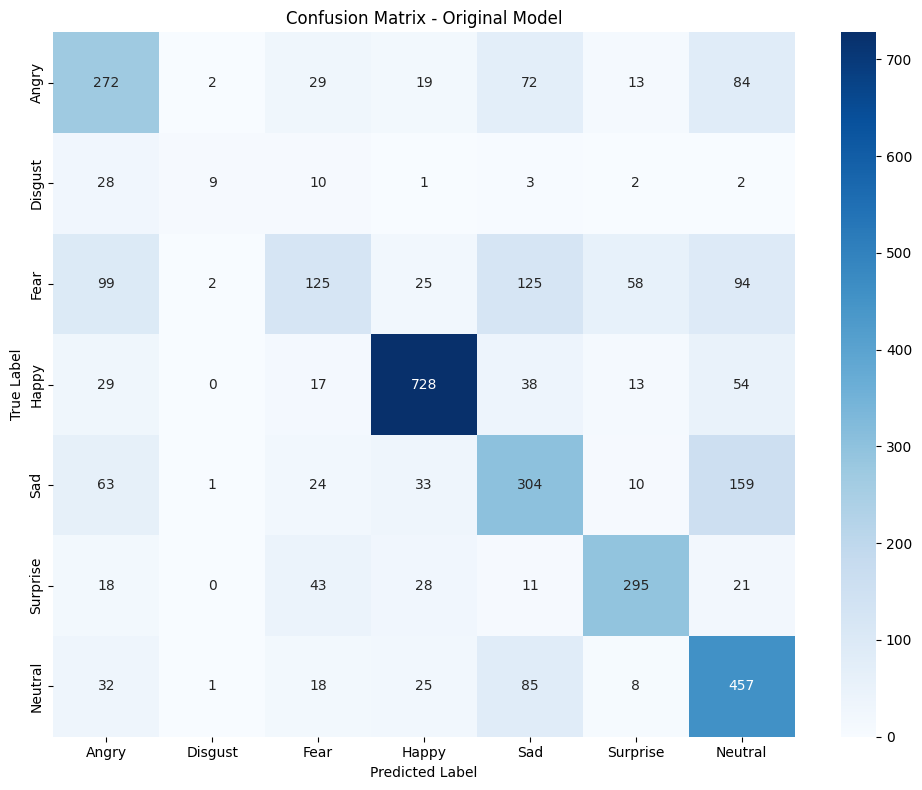

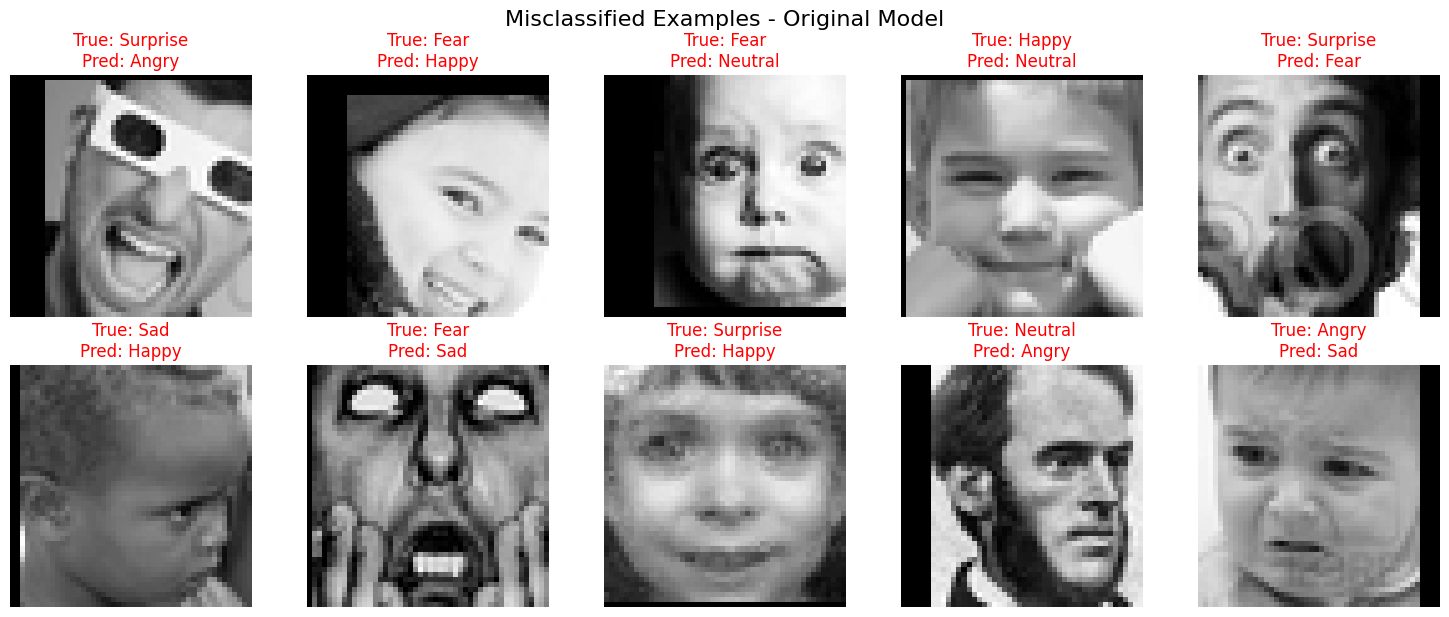

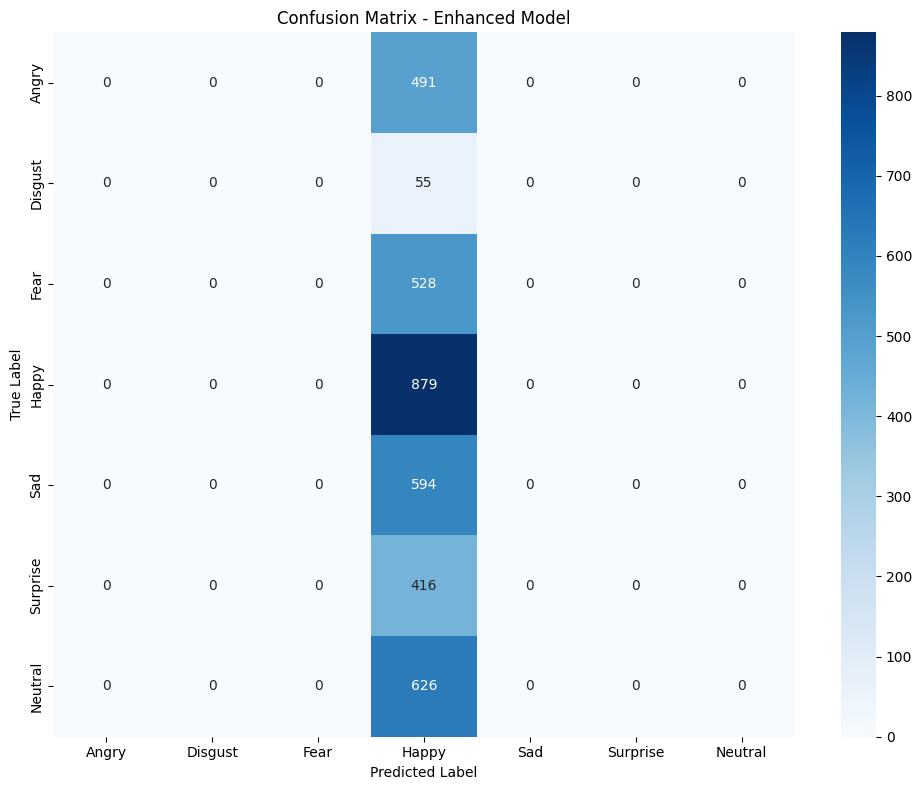

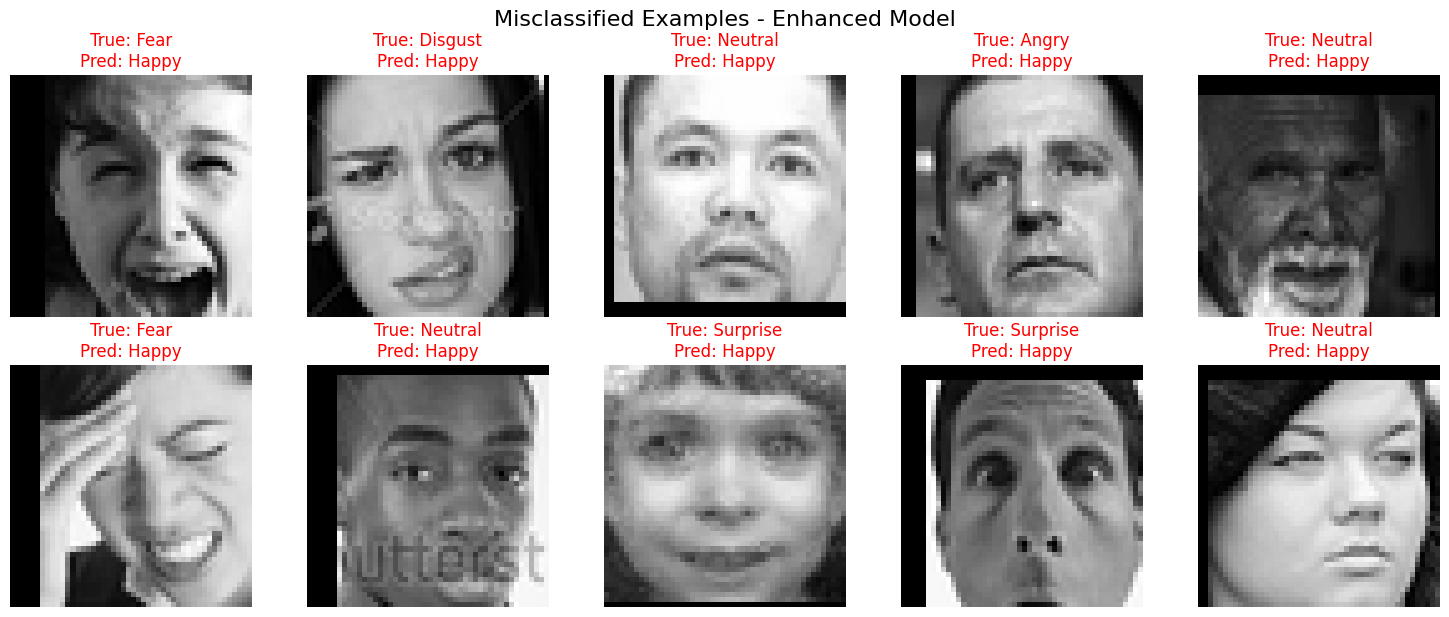

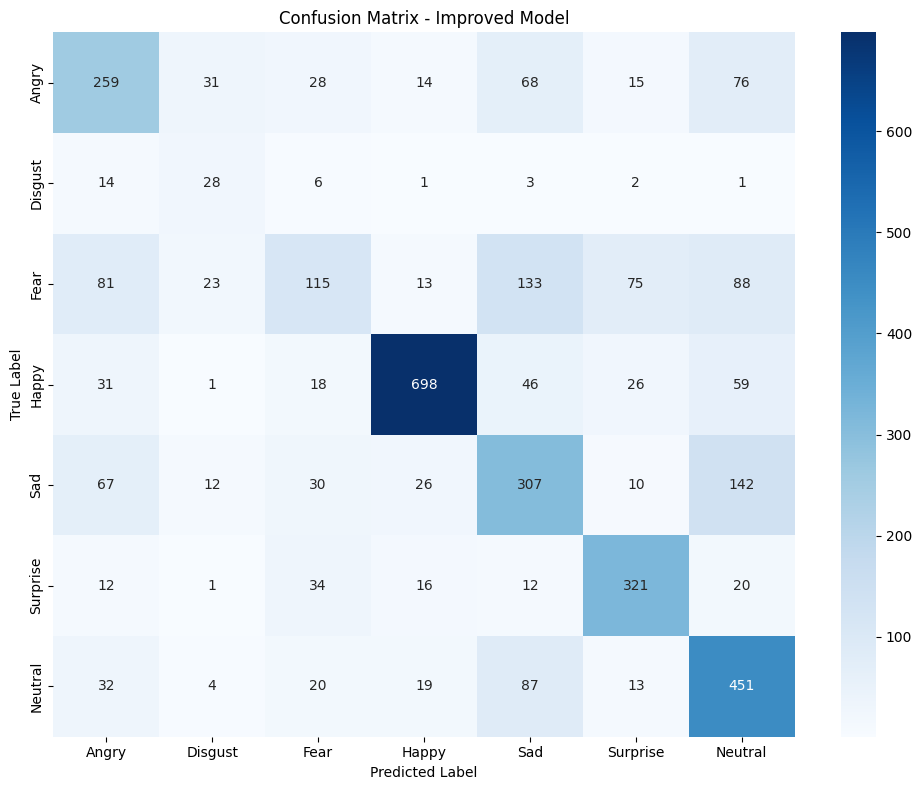

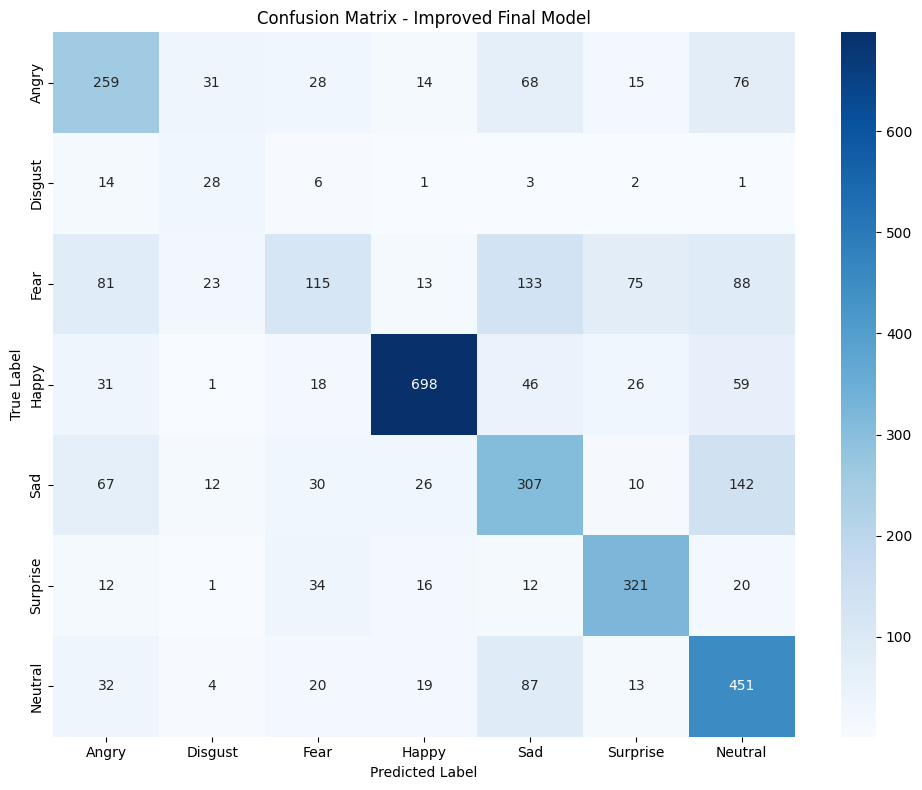

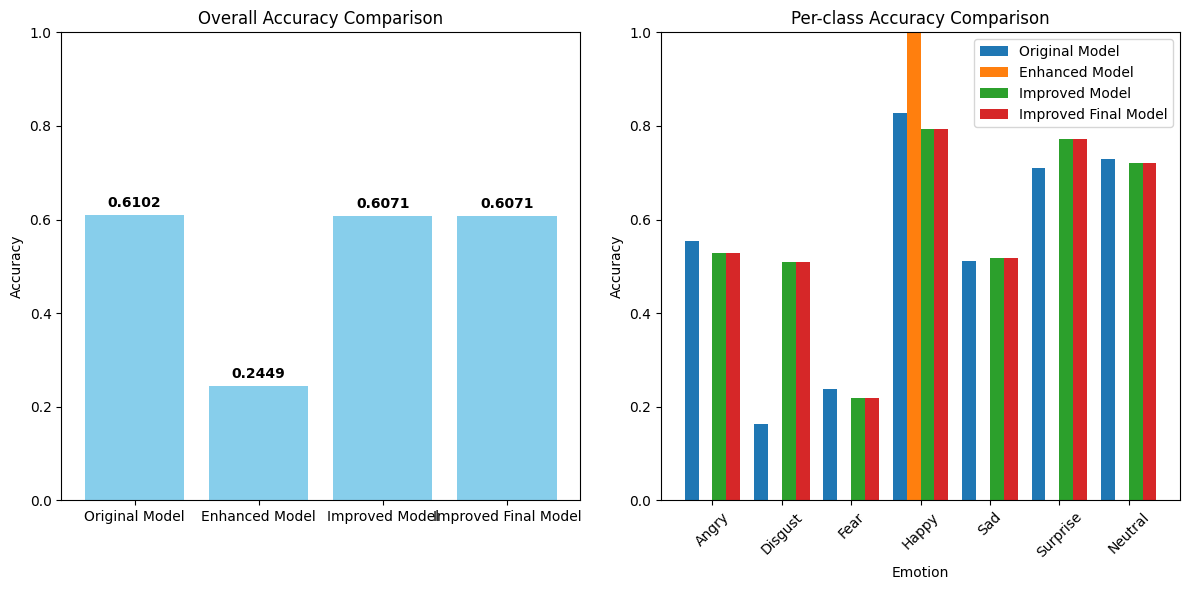


Evaluation complete!


In [16]:
if __name__ == "__main__":
    main() 